In [ ]:
# Install necessary libraries done on Google Colab
# If you are running this on your local machine, please install the following libraries:

!pip install transformers accelerate bitsandbytes sentencepiece

!pip install datasets



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_sample = pd.read_csv("/content/sampled_glassdoor_reviews.csv")

df_sample.head()

,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,Management,Post Title,Pros,Cons,pros_length,cons_length,Review_Combined,Review_Clean
0,KPMG,2021-03-01,Associate,"New York, NY",4,2,4,4,4,3,4,Good & bad,Great environment for career growth,Long hours - really long hours,5,6,Great environment for career growth Long hours...,great environment career growth long hour long...
1,KPMG,2020-12-23,Advisory Associate,"Santa Clara, CA",4,3,3,4,3,3,3,Flexible firm with good people,I love the people I work with and the firm has...,"Pay and hours, but there is a lot of upward mo...",15,11,I love the people I work with and the firm has...,love people work firm flexible pay hour lot up...
2,Korn-Ferry,2019-06-17,Talent Acquisition Specialist,"Auckland, Auckland",4,4,4,4,4,2,4,"Overall, a positive experience","Plenty of opportunities to grow your career, a...","Below market salaries, a lot of additional adm...",22,11,"Plenty of opportunities to grow your career, a...",plenty opportunity grow career supportive frie...
3,Deloitte,2020-06-23,Anonymous Employee,Unknown,4,3,3,4,3,3,3,great place to grow your career,offers great learning opportunities through it...,long hours + travel; changing expectations,15,6,offers great learning opportunities through it...,offer great learn opportunity apprenticeship m...
4,Oracle,2013-07-04,Senior Field Support Engineer,"Houston, TX",3,4,3,4,3,5,3,Okay to work for,Great benefits. They really know their stuff ...,Company does not seem to understand hardware s...,15,8,Great benefits. They really know their stuff ...,great benefit know stuff come well company un...


In [ ]:


my_token = "please_use_your_huggingface_token_here"

# Load the Mistral-7B-Instruct model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", use_auth_token=my_token)

# Configure BitsAndBytes for 8-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_use_double_quant=True,  # Enable double quantization for better performance
    bnb_8bit_quant_type="nf4",  
    llm_int8_enable_fp32_cpu_offload=True  # Enable offloading to CPU for 32-bit parts if needed
)

# Load the model with BitsAndBytes configuration
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    use_auth_token=my_token,
    quantization_config=bnb_config,  # Pass the quantization config
    device_map="auto",
)

# Create a text-generation pipeline for Mistral
mistral_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=20,
    temperature=0.1,
    do_sample=True
)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Device set to use cuda:0


In [5]:
import torch
torch.cuda.empty_cache()  # Clear PyTorch CUDA cache

prompt engineering on pretrained Mistral model.

**Types of prompts**

Prompt Variations:
Create several versions of prompts (with or without few-shot examples).
For example:

zero-shot Prompt:
"Classify the following review into a rating from 1 (very negative) to 5 (very positive): '<Review>'"

Elaborated Prompt:
"Given the following employee review, please provide a sentiment rating between 1 and 5 stars, where 1 indicates very negative sentiment and 5 indicates very positive sentiment. Consider all aspects such as work-life balance, management quality, and benefits. Review: '<Review>'"

Few-Shot Prompt: Include two example reviews with their ratings, then follow with the target review.

https://huggingface.co/docs/transformers/en/tasks/prompting

In [6]:
import re



def zero_shot_prompt(review):
    return f"""You are a helpful AI assistant that analyzes employee reviews.

    Review: "{review}"

    Please classify the sentiment as an integer from 1 (very negative) to 5 (very positive).
    Respond with only the number.

    Rating:"""


def few_shot_prompt(review):
    return f"""You are a helpful AI assistant that classifies reviews.

    Example 1:
    Review: "The work environment is amazing with supportive colleagues and excellent leadership."
    Rating: 5

    Example 2:
    Review: "The company suffers from poor management and minimal growth opportunities."
    Rating: 2

    Now classify this review:
    Review: "{review}"
    Rating:"""


def get_mistral_rating(prompt_func, review):
    prompt_text = prompt_func(review)
    response = mistral_pipe(prompt_text, max_new_tokens=20, do_sample=False)[0]["generated_text"]


    output_part = response.replace(prompt_text, "").strip()

    # Using  regex to find rating as a digit from 1 to 5
    match = re.search(r"(?<!\d)([1-5])(?!\d)", output_part)
    rating = int(match.group(1)) if match else None

    return rating, prompt_text, response


# sample_zero_shot_review = "I love the supportive team and flexible work hours, though sometimes the workload can be overwhelming."
# rating, prompt_text, response_text = get_mistral_rating(zero_shot_prompt, sample_zero_shot_review)
# print("Prompt used:\n", prompt_text)
# print("Generated response:\n", response_text)
# print("Parsed Rating:", rating)

# sample_review = "I love the supportive team and flexible work hours, though sometimes the workload can be overwhelming."
# rating, prompt_text, response_text = get_mistral_rating(few_shot_prompt, sample_review)
# print("Prompt used:\n", prompt_text)
# print("Generated response:\n", response_text)
# print("Parsed Rating:", rating)

In [ ]:


sample_size = 100
sample_reviews = df_sample["Review_Clean"].iloc[:sample_size].tolist()

results = []

# Define a dictionary for prompt function names and functions.
prompt_types = {
    "Zero-Shot": zero_shot_prompt,
    "Few-Shot": few_shot_prompt
}

# Loops over each prompt type and each review, then store the outputs.
for prompt_name, prompt_func in prompt_types.items():
    print(f"Processing prompt type: {prompt_name}")
    for review in tqdm(sample_reviews):
        predicted_rating, used_prompt, generated_text = get_mistral_rating(prompt_func, review)
        if review == sample_reviews[0]:
            print("DEBUG OUTPUT:")
            print("Prompt:\n", used_prompt)
            print("Response:\n", generated_text)
            print("Predicted Rating:", predicted_rating)
            print("\n")

        # Match original rating
        matching_row = df_sample[df_sample["Review_Clean"] == review]
        original_rating = matching_row["Overall Rating"].values[0] if not matching_row.empty else None

        results.append({
            "Prompt_Type": prompt_name,
            "Review": review,
            "Used_Prompt": used_prompt,
            "Generated_Text": generated_text,
            "Predicted_Rating": predicted_rating,
            "Actual_Rating": df_sample["Overall Rating"].iloc[sample_reviews.index(review)]
        })

        torch.cuda.empty_cache()  # Clear CUDA cache after each review


df_results = pd.DataFrame(results)

print(df_results.head())


df_results.to_csv("mistral_prompt_comparison.csv", index=False)

Processing prompt type: Zero-Shot


  1%|          | 1/100 [00:04<07:06,  4.30s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


DEBUG OUTPUT:
Prompt:
 You are a helpful AI assistant that analyzes employee reviews.

    Review: "great environment career growth long hour long hour"

    Please classify the sentiment as an integer from 1 (very negative) to 5 (very positive).
    Respond with only the number.

    Rating:
Response:
 You are a helpful AI assistant that analyzes employee reviews.

    Review: "great environment career growth long hour long hour"

    Please classify the sentiment as an integer from 1 (very negative) to 5 (very positive).
    Respond with only the number.

    Rating: 5. The review mentions a "great environment" and "career growth," which
Predicted Rating: 5




 10%|█         | 10/100 [00:33<04:58,  3.31s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 100/100 [05:27<00:00,  3.27s/it]


Processing prompt type: Few-Shot


  1%|          | 1/100 [00:03<05:34,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


DEBUG OUTPUT:
Prompt:
 You are a helpful AI assistant that classifies reviews.

    Example 1:
    Review: "The work environment is amazing with supportive colleagues and excellent leadership."
    Rating: 5

    Example 2:
    Review: "The company suffers from poor management and minimal growth opportunities."
    Rating: 2

    Now classify this review:
    Review: "great environment career growth long hour long hour"
    Rating:
Response:
 You are a helpful AI assistant that classifies reviews.

    Example 1:
    Review: "The work environment is amazing with supportive colleagues and excellent leadership."
    Rating: 5

    Example 2:
    Review: "The company suffers from poor management and minimal growth opportunities."
    Rating: 2

    Now classify this review:
    Review: "great environment career growth long hour long hour"
    Rating: 4

    Based on the context, this review seems to be expressing a positive sentiment
Predicted Rating: 4




100%|██████████| 100/100 [05:34<00:00,  3.35s/it]

  Prompt_Type                                             Review  \
0   Zero-Shot  great environment career growth long hour long...   
1   Zero-Shot  love people work firm flexible pay hour lot up...   
2   Zero-Shot  plenty opportunity grow career supportive frie...   
3   Zero-Shot  offer great learn opportunity apprenticeship m...   
4   Zero-Shot  great benefit  know stuff come well company un...   

                                         Used_Prompt  \
0  You are a helpful AI assistant that analyzes e...   
1  You are a helpful AI assistant that analyzes e...   
2  You are a helpful AI assistant that analyzes e...   
3  You are a helpful AI assistant that analyzes e...   
4  You are a helpful AI assistant that analyzes e...   

                                      Generated_Text  Predicted_Rating  \
0  You are a helpful AI assistant that analyzes e...               5.0   
1  You are a helpful AI assistant that analyzes e...               5.0   
2  You are a helpful AI assistan

In [8]:
df_results.head(120)

,Prompt_Type,Review,Used_Prompt,Generated_Text,Predicted_Rating,Actual_Rating
0,Zero-Shot,great environment career growth long hour long...,You are a helpful AI assistant that analyzes e...,You are a helpful AI assistant that analyzes e...,5.0,4
1,Zero-Shot,love people work firm flexible pay hour lot up...,You are a helpful AI assistant that analyzes e...,You are a helpful AI assistant that analyzes e...,5.0,4
2,Zero-Shot,plenty opportunity grow career supportive frie...,You are a helpful AI assistant that analyzes e...,You are a helpful AI assistant that analyzes e...,5.0,4
3,Zero-Shot,offer great learn opportunity apprenticeship m...,You are a helpful AI assistant that analyzes e...,You are a helpful AI assistant that analyzes e...,5.0,4
4,Zero-Shot,great benefit know stuff come well company un...,You are a helpful AI assistant that analyzes e...,You are a helpful AI assistant that analyzes e...,5.0,3
...,...,...,...,...,...,...
115,Few-Shot,recommend teamwork commitment good peer pressu...,You are a helpful AI assistant that classifies...,You are a helpful AI assistant that classifies...,4.0,5
116,Few-Shot,dhl repute organization learn thorough challenge,You are a helpful AI assistant that classifies...,You are a helpful AI assistant that classifies...,3.0,5
117,Few-Shot,company invest training collegues nice promo...,You are a helpful AI assistant that classifies...,You are a helpful AI assistant that classifies...,3.0,4
118,Few-Shot,friendly management good bonus fine jpm amazin...,You are a helpful AI assistant that classifies...,You are a helpful AI assistant that classifies...,4.0,5


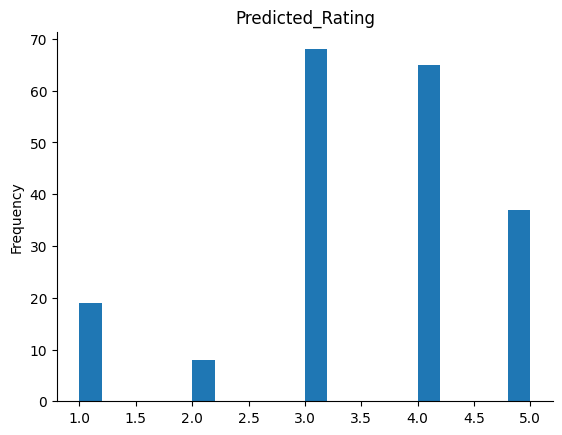

In [9]:
# @title Predicted_Rating

from matplotlib import pyplot as plt
df_results['Predicted_Rating'].plot(kind='hist', bins=20, title='Predicted_Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

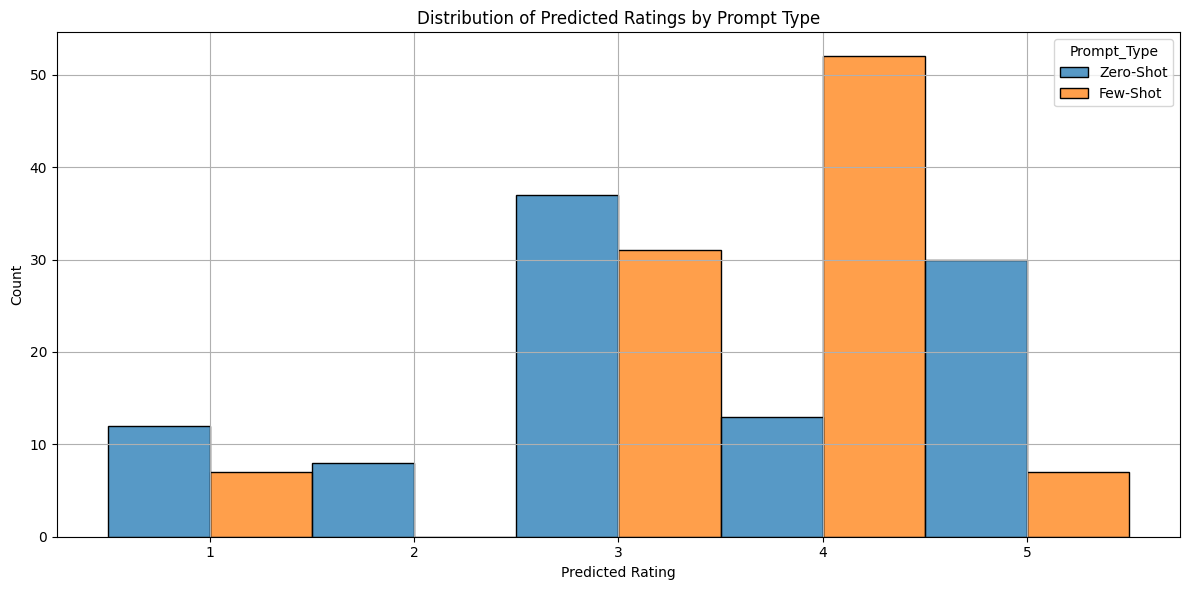

  Prompt_Type  Accuracy  F1 Score
0    Few-Shot  0.525773  0.500665
1   Zero-Shot  0.320000  0.306280


In [ ]:
# predicted rating distribution between prompts

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score


df_results= df_results.dropna(subset=["Predicted_Rating"])

# Convert ratings to integers for comparison
df_results["Predicted_Rating"] = df_results["Predicted_Rating"].astype(int)
df_results["Actual_Rating"] = df_results["Actual_Rating"].astype(int)


# Group by prompt type and calculate evaluation metrics
summary = df_results.groupby("Prompt_Type").apply(
    lambda x: pd.Series({
        "Accuracy": accuracy_score(x["Actual_Rating"], x["Predicted_Rating"]),
        "F1 Score": f1_score(x["Actual_Rating"], x["Predicted_Rating"], average="weighted")
    })
).reset_index()

# Plot histogram of predicted ratings for each prompt type
plt.figure(figsize=(12, 6))
sns.histplot(data=df_results, x="Predicted_Rating", hue="Prompt_Type", multiple="dodge", bins=5, discrete=True)
plt.title("Distribution of Predicted Ratings by Prompt Type")
plt.xlabel("Predicted Rating")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


print(summary)


<Figure size 600x500 with 0 Axes>

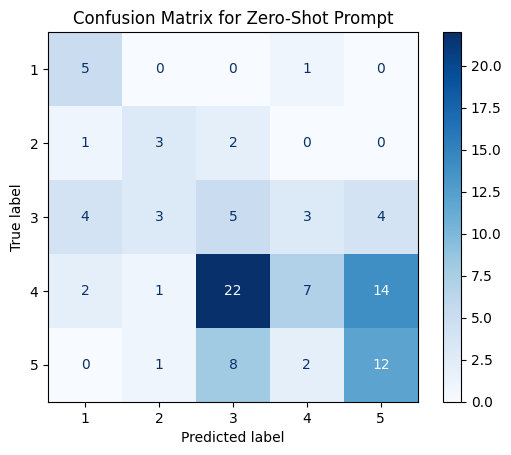

<Figure size 600x500 with 0 Axes>

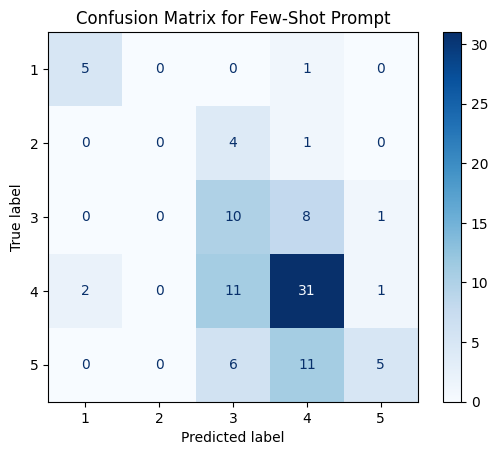

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for each prompt type
for prompt in df_results["Prompt_Type"].unique():
    subset = df_results[df_results["Prompt_Type"] == prompt]
    cm = confusion_matrix(subset["Actual_Rating"], subset["Predicted_Rating"], labels=[1, 2, 3, 4, 5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix for {prompt} Prompt")
    plt.grid(False)
    plt.show()

In [ ]:
# Filter misclassified examples where the absolute difference is 2 or more
df_misclassified = df_results[abs(df_results["Predicted_Rating"] - df_results["Actual_Rating"]) >= 2]

# Sample a few for manual inspection from each prompt type
misclassified_samples = df_misclassified.groupby("Prompt_Type").apply(lambda x: x.sample(n=5, random_state=42)).reset_index(drop=True)


misclassified_samples = misclassified_samples[[
    "Prompt_Type", "Review", "Used_Prompt", "Generated_Text", "Predicted_Rating", "Actual_Rating"
]]


print(misclassified_samples)


df_misclassified.to_csv("mistral_misclassified.csv", index=False)


  Prompt_Type                                             Review  \
0    Few-Shot  pay fantastic people great smart funny work ha...   
1    Few-Shot  free pizza helpful colleague fast pace environ...   
2    Few-Shot     good pay hard free meal overwork customer rude   
3    Few-Shot  staff alright work work enviroment calm collec...   
4    Few-Shot  time flexible schedule management experience e...   
5   Zero-Shot  great benefit  know stuff come well company un...   
6   Zero-Shot  staff alright work work enviroment calm collec...   
7   Zero-Shot    good foundation work experience focus work team   
8   Zero-Shot  lay hour slow pretty easily want word word pay...   
9   Zero-Shot  pay fantastic people great smart funny work ha...   

                                         Used_Prompt  \
0  You are a helpful AI assistant that classifies...   
1  You are a helpful AI assistant that classifies...   
2  You are a helpful AI assistant that classifies...   
3  You are a helpful AI ass

Implementing Mistral few-shot prompt onto actual sample data (5,000 rows)

In [13]:
df = pd.read_csv("/content/sampled_glassdoor_reviews.csv")


### Few shot prompt used on the sample dataset

In [14]:
import re

def few_shot_prompt(review):
    return f"""You are a helpful AI assistant that classifies reviews.

    Example 1:
    Review: "The work environment is amazing with supportive colleagues and excellent leadership."
    Rating: 5

    Example 2:
    Review: "The company suffers from poor management and minimal growth opportunities."
    Rating: 2

    Now classify this review:
    Review: "{review}"
    Rating:"""


def predict_rating(prompt_func, review):
    prompt_text = prompt_func(review)
    response = mistral_pipe(prompt_text, max_new_tokens=20, do_sample=False)[0]["generated_text"]


    output_part = response.replace(prompt_text, "").strip()

    # Using  regex to find rating as a digit from 1 to 5
    match = re.search(r"(?<!\d)([1-5])(?!\d)", output_part)
    rating = int(match.group(1)) if match else None

    return rating, prompt_text, response


#### Using batching to not overload memmory space

In [15]:
# Adjust batch size (50 or 100 should be fine in this setup)
BATCH_SIZE = 100

# Prepare storage
ratings = []
prompts = []
responses = []

# Batched prediction loop
for start in tqdm(range(0, len(df), BATCH_SIZE)):
    batch_df = df.iloc[start:start+BATCH_SIZE]

    for review in batch_df["Review_Clean"]:
        rating, prompt, response = predict_rating(few_shot_prompt, review)
        ratings.append(rating)
        prompts.append(prompt)
        responses.append(response)

    torch.cuda.empty_cache()



Streaming output truncated to the last 5000 lines.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generatio

In [ ]:


df["Mistral_Predicted_Rating"] = ratings
df["Mistral_Prompt"] = prompts
df["Mistral_Response"] = responses


df.to_csv("predicted_reviews.csv", index=False)


Check for missing val? why is there ?

In [30]:

# find missing values
df.isnull().sum()

,0
Company,0
Date Posted,0
Job Title,0
Location,0
Overall Rating,0
Work/Life Balance,0
Company Culture,0
Diversity Inclusion,0
Career Opportunity,0
Company Benefits,0


In [35]:
# delete rows with misisng values
df = df.dropna()

df.isnull().sum()

,0
Company,0
Date Posted,0
Job Title,0
Location,0
Overall Rating,0
Work/Life Balance,0
Company Culture,0
Diversity Inclusion,0
Career Opportunity,0
Company Benefits,0


In [38]:
accuracy = accuracy_score(df["Overall Rating"], df["Mistral_Predicted_Rating"]),
F1score = f1_score(df["Overall Rating"], df["Mistral_Predicted_Rating"], average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", F1score)

Accuracy: (0.3806571605703658,)
F1 Score: 0.3498251374470439


why did accuracy drop down, something to talk about in the report

In [40]:
print(classification_report(df["Overall Rating"], df["Mistral_Predicted_Rating"], digits=3))


              precision    recall  f1-score   support

           1      0.534     0.430     0.477       344
           2      0.500     0.002     0.005       436
           3      0.304     0.493     0.376      1114
           4      0.387     0.558     0.457      1603
           5      0.558     0.186     0.279      1342

    accuracy                          0.381      4839
   macro avg      0.457     0.334     0.319      4839
weighted avg      0.436     0.381     0.350      4839



what does itell us

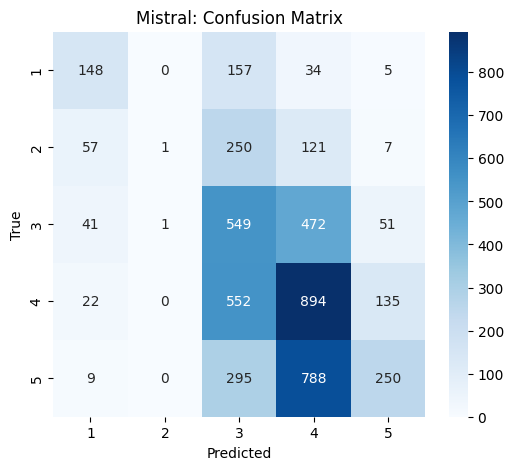

In [41]:
cm = confusion_matrix(df["Overall Rating"], df["Mistral_Predicted_Rating"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1,6), yticklabels=range(1,6))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Mistral: Confusion Matrix")
plt.show()

^ explanation - how many missclassifications there are. If it is strong at classifiying there would be a clear diagnoal line reading the correct classified labels

In [42]:
df_errors = df[df["Overall Rating"] != df["Mistral_Predicted_Rating"]]
df_errors[["Review_Clean", "Overall Rating", "Mistral_Predicted_Rating"]].sample(10)

,Review_Clean,Overall Rating,Mistral_Predicted_Rating
2099,great work pressure work time great people gre...,3,5.0
4285,worldwide know establish company big company l...,5,3.0
1877,flexibility growth exposure team opportunitie ...,5,3.0
4721,dynamic workflow good internal opportunity slo...,4,3.0
1077,leader market possibility get touch different ...,3,4.0
3288,good starter job example bad customer question...,3,1.0
1083,hand sort consult style crazy pressure time f...,3,4.0
1913,learn new thing grip product comment con,4,3.0
1202,lose experienced colleague ready share knowled...,5,4.0
3926,work home option good work culture facility fr...,5,4.0
